In [1]:
import sys
sys.path.append('../sample/')
from ann_2 import NeuralNetwork

sys.path.append('../../')
from little_mcmc.sample.mcmc import single_chain_mcmc, relative_gain

import numpy as np
from random import gauss, random
from time import time
import matplotlib.pyplot as plt

Typing Hint:

In [2]:
from typing import List, Tuple, Mapping

Array = np.array(List[float])
Value = float

### Set global variables:

In [3]:
# Ann
net_size = [5, 1]
input_size = 1
init_weight_range = [-0.05, 0.05]


#MCMC
step_length = 0.5
mcmc_threshold = 0.01

chain_num = 1
goal = 0.001
iterations = 10 ** 3

### Set error-function as, e.g.,

In [4]:
def error_function(outputs: Array, targets: Array) -> float:
    
    assert len(outputs) == len(targets)
    
    return 0.5 * np.sum(np.square(outputs - targets))

## Aim: fit `[0.5 * sin(x) for x in np.linspace(-7, 7, 20)]`.

### Preparing for MCMC

In [5]:
def random_move(net: NeuralNetwork, step_length=step_length) -> NeuralNetwork:
    
    result = NeuralNetwork(net.size, net.input_size)
    
    for l, layer in enumerate(net.weights):
        for p, perceptron in enumerate(layer):
            for w, weight in enumerate(perceptron):
                result.weights[l][p][w] = weight + gauss(0, 1) * step_length
    
    return result

Test:

In [6]:
init_net = NeuralNetwork(net_size, input_size)
print(init_net.weights)

result_net = random_move(init_net)
print(result_net.weights)

[[[0.03334316061055381, -0.012583307392157954], [0.004973503348402054, -0.03557069229744772], [-0.024973705739522113, -0.020248192673578958], [0.016863425936670548, 0.033914532249602364], [-0.015304207872032016, -0.021740157612460367]], [[-0.010696380040514673, 0.004096626227990743, 0.034480603808130283, -0.03130701760227292, -0.026294468448447485, 0.04364711280324464]]]
[[[0.04946955981673096, 0.15759109853960393], [0.29506829293516684, 0.11021725727752898], [0.2809055797565981, -0.47914587118556273], [0.1073073197122072, 0.2558399302121846], [0.08097943604871717, -0.39871830693064125]], [[0.469912734469433, 0.10998693226400741, 0.2139205988781759, 1.0614724064089813, -0.37444969039337617, -0.02923965270309413]]]


So far so good.

Function to maximize:

In [7]:
# Input
x = np.linspace(-7, 7, 20)

# Target
y = np.sin(x) * 0.5
y = np.square(x)


def f(net: NeuralNetwork, inputs=x, targets=y) -> Value:
        
    outputs = np.array([net.outputs([__])[-1][0] for __ in inputs])
    
    return -1 * error_function(outputs, targets) # so that it has maximum.

Test

In [8]:
net = NeuralNetwork([2, 1], 1)
f(net)

-5666.4378181124093

So far so good.

### Gradiant

In [9]:
def grad(f, net, delta=0.001, threshold=0):
    
    def move_along_weight_axis(net, position):
        
        result = net.copy()
        
        l = position[0]
        p = position[1]
        w = position[2]
        
        result.weights[l][p][w] += delta
        
        return result
    
    result = []
    
    f_value_0 = f(net)
    
    for i, layer in enumerate(net.weights):
        
        result_p = []
        
        for j, perceptron in enumerate(layer):
            
            result_w = []
            
            for k, weight in enumerate(perceptron):
                
                position = [i, j, k]
                f_value_1 = f(move_along_weight_axis(net, position))
                
                delta_f = (f_value_1 - f_value_0) / delta
                
                if abs(delta_f) < threshold:
                    result_w.append(0)
                    
                else:
                    result_w.append(delta_f)
                
            result_p.append(result_w)
            
        result.append(result_p)
        
    return result

def minQ(f, net, dela=0.001, tolerence=0.001):
    g = grad(f, net, delta)
    
    result = True
    
    for i in range(len(g)):
        for j in range(len(g[i])):
            for k in range(len(g[k])):
                
                if abs(g[i][j][k]) < tolerence:
                    return False
    
    return result

In [10]:
net = NeuralNetwork(net_size, input_size)
grad(f, net)

[[[0.0037031513784313574, 0.59478783623490017],
  [-0.0004336834535934031, -0.85603814022761071],
  [-0.0033812102628871799, -0.63043662066775141],
  [-0.0093785447461414151, -0.68799970540567301],
  [0.0022672938939649612, 1.035038795635046]],
 [[43.514970579963119,
   43.828829018821125,
   44.075533894101682,
   44.358434292007587,
   44.9703126323584,
   87.779177271841036]]]

## Test Single Chain MCMC

In [11]:
t_begin = time()

init_net = NeuralNetwork(net_size, input_size, init_weight_range=init_weight_range)

net_chain = single_chain_mcmc(f, random_move, init_net, 0.001, 3000, 10 ** 5)

t_end = time()
print('time spent by fitting: ', t_end - t_begin)

time spent by fitting:  2.872025966644287


Show and Plot Results:

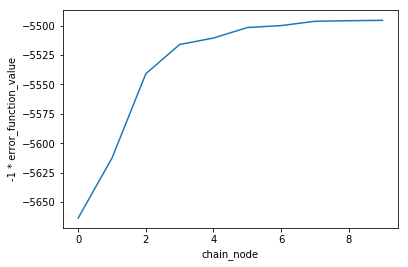

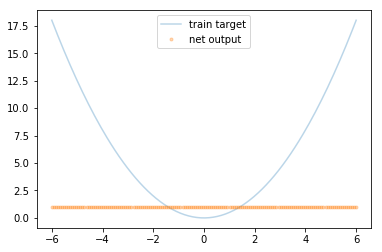

gradient = [[[0.039731105061946437, 0.012079374755558092], [0, 0], [0.0012653572412091307, 0], [0.026157953470828943, 0.0054880665629752912], [-0.034799159038811922, 0.0097542470030020922]], [[0.022368171812559012, 0.02616363599372562, 0.021302881577867083, 0.030803163099335507, 0.017784394003683701, 0.047233010263880715]]].


In [12]:
error_function_values = [__[1] for __ in net_chain]
plt.plot([i for i in range(len(error_function_values))],
         error_function_values)
plt.xlabel('chain_node')
plt.ylabel('-1 * error_function_value')
plt.show()


best_net = net_chain[-1][0]

plot_x = np.linspace(-6.0,6.0,150)
plot_y_ann = np.array([best_net.outputs([__])[-1][0] for __ in plot_x])
plot_y_target = np.sin(plot_x) * 0.5
plot_y_target = np.square(plot_x) * 0.5


plt.plot(plot_x, plot_y_target, '-',
         plot_x, plot_y_ann, '.', alpha = 0.3
        )
plt.legend(['train target', 'net output'])
plt.show()

print("gradient = {0}.".format(grad(f, best_net, threshold=0.001)))

Why???

In [13]:
for step in range(100):
    rg = relative_gain(f(best_net), f(random_move(best_net)))
    if rg > 0:
        print(step, rg)

2 1.9322665472e-06
3 3.59748129422e-07
12 1.37302179956e-06
17 2.30294210692e-06
21 1.76100752838e-06
32 2.69659847666e-06
37 2.67486817002e-06
38 1.63821405083e-06
39 9.79549379575e-07
48 2.81422362725e-06
49 2.36690612795e-06
50 3.08571954153e-06
54 1.95931215951e-06
57 2.40062653201e-06
63 3.34920869321e-06
66 5.93511466177e-08
68 1.79062359019e-06
70 1.12320484471e-07
71 1.3039408856e-06
78 2.87045687074e-07
90 1.78317070464e-07
96 3.73819807824e-06
97 1.67047153957e-06
98 2.06541264642e-06


It seems that the reason is that my `relative_gain` is not suitably defined. Indeed, comparing to gradient, **its order** is quite small.

Let's move the best_net a little by its gradient:

In [14]:
grd = grad(f, best_net, threshold=0.001)

grd_net = NeuralNetwork(net_size, input_size)
    
for l, layer in enumerate(best_net.weights):
    for p, perceptron in enumerate(layer):
        for w, weight in enumerate(perceptron):
            grd_net.weights[l][p][w] = weight + 1 * grd[l][p][w]
    
relative_gain(f(best_net), f(grd_net))

7.2573401337332016e-07

This confirms the previous guess.

### Comparison: Single Chian GD

In [15]:
def gd(f, step_length, init_net, threshold=0.001, iterations=10 ** 5):
    
    result_chain = []
    
    for step in range(iterations):
        grd = grad(f, init_net, threshold=0.001)

        grd_net = NeuralNetwork(init_net.size, init_net.input_size)
    
        for l, layer in enumerate(init_net.weights):
            for p, perceptron in enumerate(layer):
                for w, weight in enumerate(perceptron):
                    grd_net.weights[l][p][w] = weight + step_length * grd[l][p][w]
        
        init_value = f(init_net)
        new_value = f(grd_net)
        
        if abs(new_value) < threshold:
            return result_chain
        
        else:
            result_chain.append((grd_net, new_value))
            
            init_net = grd_net.copy()
        
    if step == iterations - 1:
        print("Iteration Exhausted.")
        
    else:
        pass
            
    return result_chain

In [16]:
t_begin = time()

init_net = NeuralNetwork(net_size, input_size, init_weight_range=init_weight_range)

net_chain = gd(f, 1, init_net, threshold=0.1, iterations=10 ** 3)

t_end = time()
print('time spent by fitting: ', t_end - t_begin)

Iteration Exhausted.
time spent by fitting:  19.44237208366394


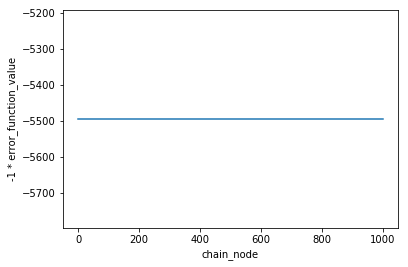

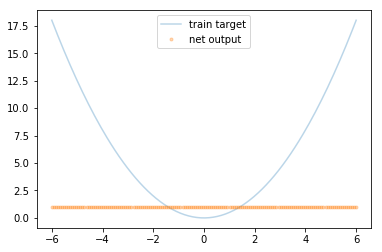

gradient = [[[0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]], [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]].


In [17]:
error_function_values = [__[1] for __ in net_chain]
plt.plot([i for i in range(len(error_function_values))],
         error_function_values)
plt.xlabel('chain_node')
plt.ylabel('-1 * error_function_value')
plt.show()


best_net = net_chain[-1][0]

plot_x = np.linspace(-6.0,6.0,150)
plot_y_ann = np.array([best_net.outputs([__])[-1][0] for __ in plot_x])
plot_y_target = np.sin(plot_x) * 0.5
plot_y_target = np.square(plot_x) * 0.5


plt.plot(plot_x, plot_y_target, '-',
         plot_x, plot_y_ann, '.', alpha = 0.3
        )
plt.legend(['train target', 'net output'])
plt.show()

print("gradient = {0}.".format(grad(f, best_net, threshold=0.0)))

In [35]:
f(random_move(best_net))

-5495.4996355153799

By running the previous code multi-times, we find that the best_net, as a local minimum, and is far from global minimum, is **rather** flat!